In [1]:
import os

import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

sns.set_style("whitegrid")

### Define static values 

In [2]:
folder = "run_results"
img_folder = "hue_sat_val"

## Load data

In [3]:
def load_data(id):
    homo_df = pd.read_csv(os.path.join(folder, f"{id}_homogeneous.csv"))
    homo_df["dataset"] = "homogeneous"
    hetero_df = pd.read_csv(os.path.join(folder, f"{id}_heterogeneous.csv"))
    hetero_df["dataset"] = "heterogeneous"
    TMA_df = pd.read_csv(os.path.join(folder, f"{id}_TMA.csv"))
    TMA_df["dataset"] = "TMA"

    df = pd.concat([homo_df, hetero_df, TMA_df], ignore_index=True)
    return df

def add_local_all(df):
    local_rows = df[df["mode"].str.contains("TMA|spl")].copy()
    local_rows["mode"] = "local"
    df = pd.concat([df, local_rows], ignore_index=True)
    return df

In [4]:
uni_df = load_data("uni")
uni_df["model"] = "UNI"

conch_df = load_data("conch")
conch_df["model"] = "CONCH"

ctranspath_df = load_data("ctranspath")
ctranspath_df["model"] = "CTransPath"

ecarenet_df = add_local_all(load_data("ecarenet"))
ecarenet_df["model"] = "eCaReNet"

full_df = pd.concat([ecarenet_df, ctranspath_df, uni_df, conch_df], ignore_index=True)

In [5]:
full_df.head()

,mode,run_id,best_epoch,replicate,accuracy,kappa,f1-score,test_dataset,accuracy_TMA20,kappa_TMA20,f1-score_TMA20,dataset,model
0,central,297.0,453,1.0,0.548931,0.699276,0.451473,spl_1,0.435897,0.599443,0.370360,homogeneous,eCaReNet
1,central,298.0,208,1.0,0.505062,0.743109,0.452178,spl_2,0.466667,0.644788,0.434281,homogeneous,eCaReNet
2,central,299.0,312,1.0,0.513363,0.689763,0.431824,spl_3,0.476923,0.673405,0.436159,homogeneous,eCaReNet
3,central,306.0,275,2.0,0.554556,0.703341,0.445511,spl_1,0.456410,0.619608,0.395711,homogeneous,eCaReNet
4,central,307.0,103,2.0,0.505062,0.746437,0.444929,spl_2,0.441026,0.666023,0.403101,homogeneous,eCaReNet


## Figure 4

In [6]:
img_df = pd.read_csv(os.path.join(img_folder, "mean_images.csv"))

In [7]:
heat_ecarenet_df = pd.read_csv(os.path.join(folder, f"ecarenet_TMA.csv"))
heat_ecarenet_df["model"] = "eCaReNet"
heat_ctranspath_df = pd.read_csv(os.path.join(folder, f"ctranspath_TMA_heat.csv"))
heat_ctranspath_df["model"] = "CTransPath"
heat_uni_df = pd.read_csv(os.path.join(folder, f"uni_TMA_heat.csv"))
heat_uni_df["model"] = "UNI"
heat_conch_df = pd.read_csv(os.path.join(folder, f"conch_TMA_heat.csv"))
heat_conch_df["model"] = "CONCH"
heatmap_df = pd.concat([heat_uni_df, heat_ctranspath_df, heat_conch_df, heat_ecarenet_df])
heatmap_df = heatmap_df[heatmap_df["mode"].str.startswith("TMA")]
heatmap_df['mode'] = heatmap_df['mode'].str.replace('_', ' ', regex=False)
heatmap_df['test_dataset'] = heatmap_df['test_dataset'].str.replace('_', ' ', regex=False)

In [8]:
def get_lists_cor(df, val_column, metric):
    block_mean_map = img_df.set_index("BLOCK#")[val_column]
    train_vals = df["mode"].str[-2:].astype(int).map(block_mean_map)
    test_vals = df["test_dataset"].str[-2:].astype(int).map(block_mean_map)

    xlist = (train_vals - test_vals).abs().tolist()
    ylist = df[metric].tolist()
    return xlist, ylist

In [9]:
def correlation_metric_delta(df, metric):
    fig, axes = plt.subplots(3, 4, figsize=(10, 6), sharey=True)
    for i, m in enumerate(["eCaReNet", "CTransPath", "UNI", "CONCH"]):
        for j, img_metr in enumerate(["hue", "saturation", "value"]):
            t_df = df[df["model"] == m]
            t_df = t_df.groupby(['mode', 'test_dataset'], as_index=False)[metric].mean()
            xlist, ylist = get_lists_cor(t_df, f"mean_mean_{img_metr[0]}", metric)
            corr_coef, p_value = stats.spearmanr(xlist, ylist)

            if i == 0:
                boxpos = (0.65,0.9)
            elif i == 1:
                boxpos = (0.05,0.43)
            elif (i == 2) and (j == 0) and (metric == "accuracy"):
                boxpos = (0.4,0.3)
            elif (i == 3):
                boxpos = (0.5,0.3)
            else:
                boxpos = (0.05,0.3)

            sns.regplot(x=xlist, y=ylist, ci=95, scatter=False, line_kws={"color": "red"}, ax=axes[j][i])
            labels = t_df["mode"].to_list()
            unique_labels = sorted(set(labels))
            palette = sns.color_palette("tab10", n_colors=len(unique_labels))
            label_to_color = dict(zip(unique_labels, palette))
            colorlist = [label_to_color[label] for label in labels]
            axes[j][i].scatter(xlist, ylist, c=colorlist, s=10)
            axes[j][i].text(boxpos[0], boxpos[1], f"ρ={corr_coef:.2f}\nP={p_value:.4f}", transform=axes[j][i].transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.5, edgecolor="gray"))

            if j == 0:
                axes[j][i].set_title(m)
            if i == 0:    
                axes[j][i].set_ylabel(metric.capitalize())
            
            delta = u"Δ"
            axes[j][i].set_xlabel(f"{delta} {img_metr.capitalize()}")

    handles = [mpatches.Patch(color=color, label=label) for label, color in label_to_color.items()]
    fig.legend(handles=handles, title="TMA training cohort", loc='upper center', ncol=len(unique_labels), bbox_to_anchor=(0.5, 0.1), frameon=True)
    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.savefig(os.path.join(img_folder, f"{metric}_correlation.png"), dpi=600)

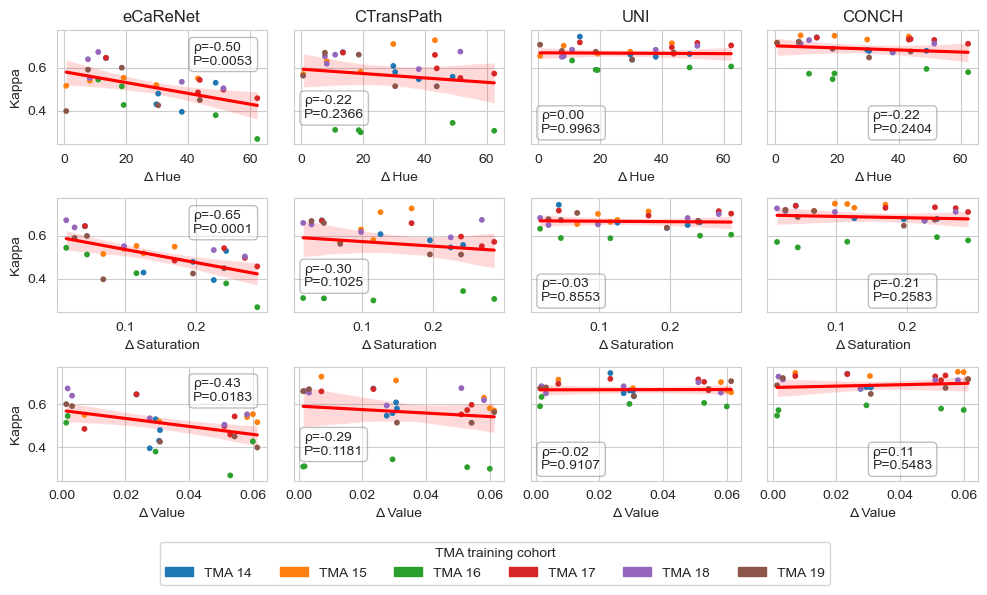

In [10]:
correlation_metric_delta(heatmap_df, "kappa")

In [11]:
def correlation_metric_delta_supp(df, metrics):
    fig, axes = plt.subplots(6, 4, figsize=(10, 12), sharey=True)

    for mi, metric in enumerate(metrics):
        for i, m in enumerate(["eCaReNet", "CTransPath", "UNI", "CONCH"]):
            for j, img_metr in enumerate(["hue", "saturation", "value"]):
                ax_row = mi * 3 + j
                ax_col = i

                t_df = df[df["model"] == m]
                t_df = t_df.groupby(['mode', 'test_dataset'], as_index=False)[metric].mean()
                xlist, ylist = get_lists_cor(t_df, f"mean_mean_{img_metr[0]}", metric)
                corr_coef, p_value = stats.spearmanr(xlist, ylist)
                labels = t_df["mode"].to_list()
                unique_labels = sorted(set(labels))
                palette = sns.color_palette("tab10", n_colors=len(unique_labels))
                label_to_color = dict(zip(unique_labels, palette))
                colorlist = [label_to_color[label] for label in labels]

                ax = axes[ax_row][ax_col]
                sns.regplot(x=xlist, y=ylist, ci=95, scatter=False, line_kws={"color": "red"}, ax=ax)
                ax.scatter(xlist, ylist, c=colorlist, s=10)

                if i == 0:
                    boxpos = (0.65,0.95)
                elif (i == 1) and ax_row == 5:
                    boxpos = (0.05,0.4)
                else:
                    boxpos = (0.43,0.28)

                ax.text(boxpos[0], boxpos[1], f"ρ={corr_coef:.2f}\nP={p_value:.4f}", transform=ax.transAxes, 
                        fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", 
                        facecolor="white", alpha=0.5, edgecolor="gray"))

                if (j + mi) == 0:
                    ax.set_title(m)
                if i == 0:
                    ax.set_ylabel(f"{metrics[mi].capitalize()}")
                else:
                    ax.set_ylabel("")
                delta = u"Δ"
                ax.set_xlabel(f"{delta} {img_metr.capitalize()}")
    
    handles = [mpatches.Patch(color=color, label=label) for label, color in label_to_color.items()]
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.legend(handles=handles, title="TMA training cohort", loc='upper center', ncol=len(unique_labels), bbox_to_anchor=(0.5, 0.99), frameon=True)
    plt.savefig(os.path.join(img_folder, f"{'_and_'.join(metrics)}_correlation.png"), dpi=600)

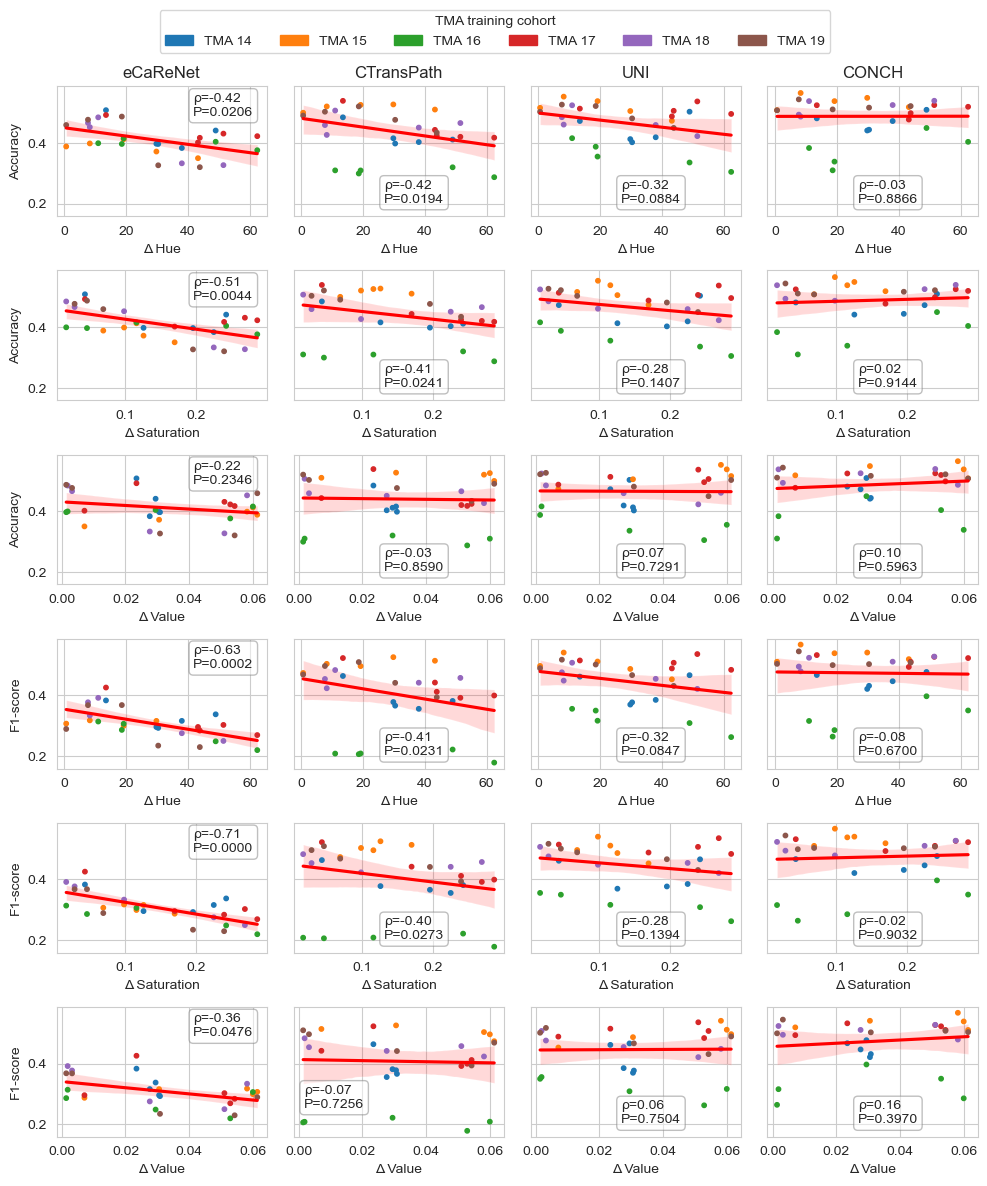

In [12]:
correlation_metric_delta_supp(heatmap_df, ["accuracy", "f1-score"])